In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from scipy import stats
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

In [13]:
Uw_dealt_median = f'/pubhome/xli02/project/PLIM/v2019_dataset/index/PLANet_Uw_dealt_median.csv'
Uw_dealt_median_df = pd.read_csv(Uw_dealt_median, sep='\t')
len(Uw_dealt_median_df)

69826

# 1. Core_set_v16

In [2]:
PDBbind_dir = '/pubhome/xli02/Downloads/dataset/PDBbind/PDBbind_v2019'

In [18]:
core_f = f'{PDBbind_dir}/CASF_v16_index_dealt.csv'
core_df = pd.read_csv(core_f, sep='\t')
core_df.head()

,pdb_id,-logAffi
0,3ao4,2.07
1,3gv9,2.12
2,1uto,2.27
3,1ps3,2.28
4,4ddk,2.29


In [4]:
len(core_df)

285

In [19]:
for row in core_df.itertuples():
    cry_lig_smi = f'{PDBbind_dir}/general_structure_only/{row.pdb_id}/{row.pdb_id}_ligand.smi'
    if Path(cry_lig_smi).exists():
        cry_lig_mol = Chem.SmilesMolSupplier(cry_lig_smi, delimiter='\t',titleLine=False)[0]
        if cry_lig_mol is not None:
            Mw = Chem.rdMolDescriptors.CalcExactMolWt(cry_lig_mol)
            core_df.loc[row.Index,'Mw'] = Mw

RDKit ERROR: [12:58:53] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [13:02:38] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [13:02:38] ERROR: Could not sanitize molecule on line 0


In [20]:
core_df

,pdb_id,-logAffi,Mw
0,3ao4,2.07,217.085127
1,3gv9,2.12,185.014664
2,1uto,2.27,122.096426
3,1ps3,2.28,232.069536
4,4ddk,2.29,166.026609
...,...,...,...
280,5dwr,11.22,441.189672
281,4f2w,11.30,294.138308
282,2x00,11.33,509.350509
283,3o9i,11.82,617.222943


In [21]:
core_df[core_df['Mw'].isna()]

,pdb_id,-logAffi,Mw
143,4mme,6.5,NaN


In [26]:
core_df_notna = core_df[core_df['Mw'].notna()].copy()
len(core_df_notna)

284

In [28]:
core_df_notna.reset_index(drop=True, inplace=True)

# 2. core_intersected_Uw

In [22]:
core_intersected_Uw_f = '/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/test_on_core_set/2-core_intersected_Uw/core_intersected_Uw.csv'
core_intersected_Uw_df = pd.read_csv(core_intersected_Uw_f, sep='\t')
core_intersected_Uw_df.head()

,pdb_id,-logAffi
0,1uto,2.27
1,3l7b,2.40
2,3udh,2.85
3,4llx,2.89
4,5aba,2.98


In [15]:
len(core_intersected_Uw_df)

115

In [23]:
for row in core_intersected_Uw_df.itertuples():
    cry_lig_smi = f'{PDBbind_dir}/general_structure_only/{row.pdb_id}/{row.pdb_id}_ligand.smi'
    if Path(cry_lig_smi).exists():
        cry_lig_mol = Chem.SmilesMolSupplier(cry_lig_smi, delimiter='\t',titleLine=False)[0]
        if cry_lig_mol is not None:
            Mw = Chem.rdMolDescriptors.CalcExactMolWt(cry_lig_mol)
            core_intersected_Uw_df.loc[row.Index,'Mw'] = Mw

In [24]:
core_intersected_Uw_df.head()

,pdb_id,-logAffi,Mw
0,1uto,2.27,122.096426
1,3l7b,2.40,275.091749
2,3udh,2.85,189.102239
3,4llx,2.89,123.079647
4,5aba,2.98,404.085521


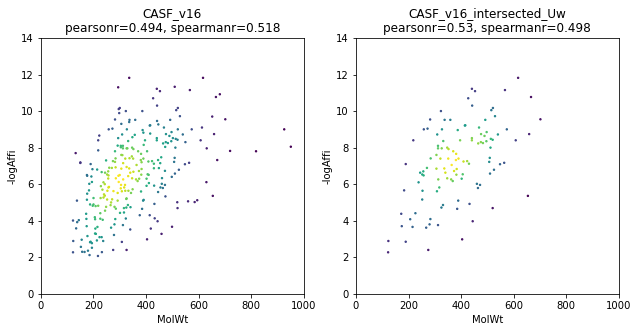

In [29]:
fig = plt.figure(figsize=(16,16))
names = ['CASF_v16', 'CASF_v16_intersected_Uw']
for i, df in enumerate([core_df_notna, core_intersected_Uw_df]):
    pearsonr = stats.pearsonr(df['Mw'], df['-logAffi'])
    spearmanr = stats.spearmanr(df['Mw'], df['-logAffi'])
    
    ax = fig.add_subplot(3, 3, i+1)
    xy = np.vstack([df['Mw'], df['-logAffi']])  #按行叠加
    g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
    z = g(xy)  #计算每个xy样本点的概率密度

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()  #对z值排序并返回索引
    y, y_, z = df['Mw'][idx], df['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

    ax.scatter(y, y_, s=2, c=z, zorder=2)
    ax.set_xlabel('MolWt')
    ax.set_ylabel('-logAffi')
    ax.set_title(f'{names[i]}\npearsonr={round(pearsonr[0],3)}, spearmanr={round(spearmanr[0],3)}')
    ax.set_xlim((0,1000))
    ax.set_ylim((0,14))
plt.savefig('/pubhome/xli02/project/PLIM/analysis/distribution/PDBbind/core_and_intersected_Uw_Affi_Mw.png', dpi=300, bbox_inches='tight')